# Loading and fitting multiple diffraction patterns

If a number of diffraction patterns are collected over time they can be automatically fitted and the change in peaks over time measured. The change in the positions or heights of the peaks can then be correlated to material properties. 

In the example files folder there is a sequence of 10 diffraction patterns which we will use for demonstation.

The first thing to do is to load an `FittingExperiment` object - this contains some metadata about the expeiment and will hold one `FitSpectrum` for each diffraction pattern.

In [1]:
%matplotlib inline

import sys
sys.path.append('./..')

import spectrum_fitting
from spectrum_fitting import PeakParams, MaximumParams


frame_time = 10
file_stub = "../example_data/adc_041_7Nb_NDload_700C_15mms_*"
first_cake_angle = 90
cakes_to_fit = [36, 1, 2]
peak_params = PeakParams('1', (2.8, 2.9))
merge_cakes = True

experiment = spectrum_fitting.FittingExperiment(frame_time, file_stub, first_cake_angle, 
                                                cakes_to_fit, peak_params, merge_cakes)

experiment.run_analysis()

Processing 10 diffusion patterns.


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.68it/s]


Analysis complete.


['1']


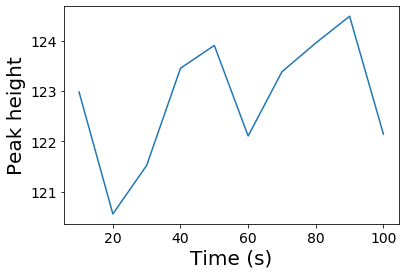

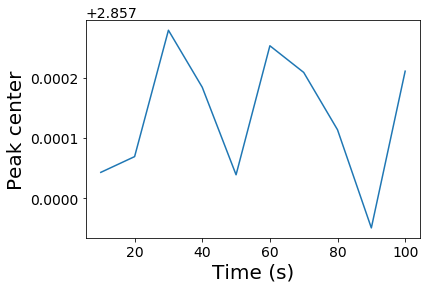

In [2]:
print(experiment.list_fits())

for peak_label in experiment.list_fits():
    experiment.plot_fit_property(peak_label, "height")
    experiment.plot_fit_property(peak_label, "center")